In [13]:
import sys
import os.path as osp

from copy import deepcopy
import datetime
import os
import pickle
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from multihist import Hist1d, Histdd
from tqdm.notebook import tqdm
import pandas as pd
from scipy import stats

import strax
import straxen
strax.utils.tqdm = tqdm  # use notebook-aware progress bar

In [17]:
import peak_s1_plots as ps1

In [2]:
st = straxen.contexts.xenonnt_online()

In [4]:
runs = st.select_runs(run_id='0085*',run_mode='*selftrigger*',available=['lone_hits','peak_basics'])

In [5]:
runs

,name,number,mode,start,end,tags,livetime,tags.name,peak_basics_available,raw_records_available,lone_hits_available
1367,008525,8525,xenonnt_selftrigger_commissioning_lowe,2020-07-08 17:09:19.500,2020-07-08 18:09:21.830,,01:00:02.330000,NaN,True,True,True
1368,008526,8526,xenonnt_selftrigger_commissioning_lowe,2020-07-08 18:09:53.945,2020-07-08 19:09:55.270,,01:00:01.325000,NaN,True,False,True
1369,008527,8527,xenonnt_selftrigger_commissioning_lowe,2020-07-08 19:10:25.380,2020-07-08 20:10:27.790,,01:00:02.410000,NaN,True,True,True
1370,008528,8528,xenonnt_selftrigger_commissioning_lowe,2020-07-08 20:10:59.912,2020-07-08 21:11:02.421,,01:00:02.509000,NaN,True,False,True
1373,008531,8531,xenonnt_selftrigger_commissioning_lowe,2020-07-08 23:12:44.149,2020-07-09 00:12:47.749,,01:00:03.600000,NaN,True,False,True
1374,008532,8532,xenonnt_selftrigger_commissioning_lowe,2020-07-09 00:13:22.873,2020-07-09 01:13:25.307,,01:00:02.434000,NaN,True,False,True


In [6]:
run_name = runs.iloc[0]['name']

In [7]:
peak_basics = st.get_array(run_name,'peak_basics',seconds_range=(0,30))

In [8]:
peak_basics = peak_basics[peak_basics['n_channels']>3]

In [75]:
def plot_area(peak_basics):
    p_area = Hist1d(peak_basics['area'], bins=(np.logspace(0, 5, 200)))
    p_area.plot()
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("events", ha='right', y=1)
    plt.xscale('log')
    plt.yscale('log')

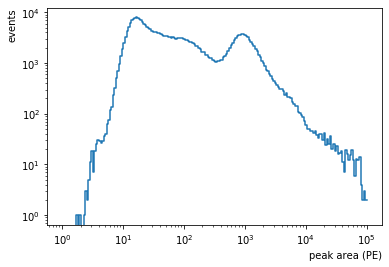

In [76]:
plot_area(peak_basics)

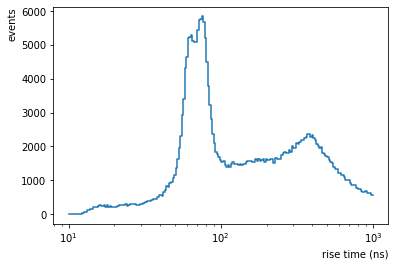

In [10]:
rise_time = Hist1d(peak_basics['rise_time'], bins=(np.logspace(1, 3, 200)))
rise_time.plot()
plt.xlabel("rise time (ns)", ha='right', x=1)
plt.ylabel("events", ha='right', y=1)
plt.xscale('log')

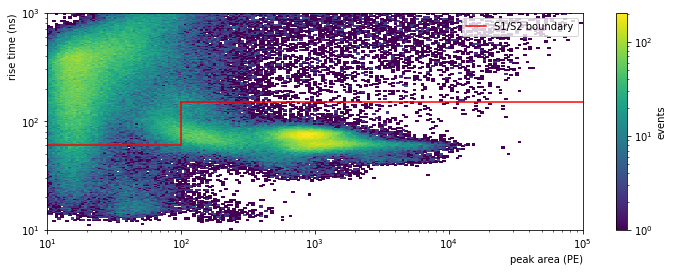

In [18]:
ps1.plot_area_risetime(peak_basics)

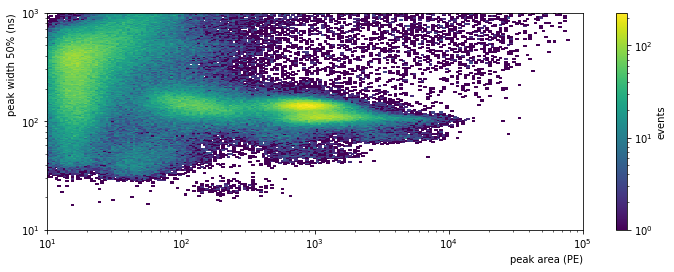

In [19]:
ps1.plot_area_width(peak_basics)

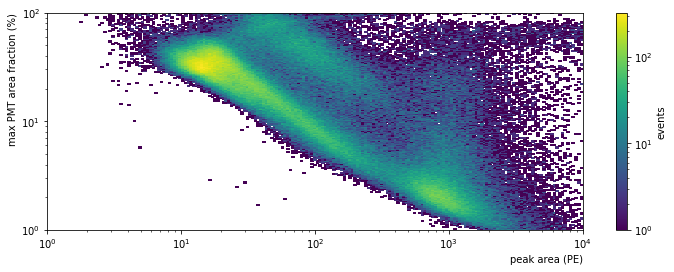

In [20]:
ps1.plot_area_maxpmt(peak_basics)

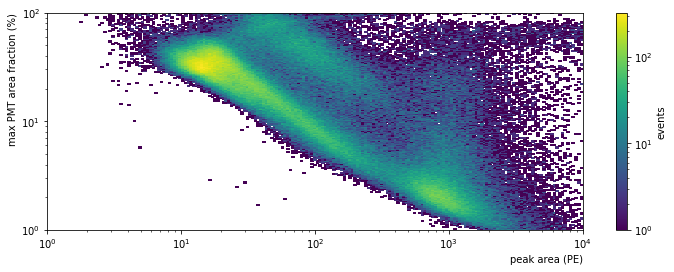

In [24]:
peak_s1 = peak_basics[(peak_basics['rise_time']<150)]
ps1.plot_area_maxpmt(peak_basics)

In [73]:
def plot_area_top(peak_basics):
    phmax = Histdd(peak_basics['area'], peak_basics['area_fraction_top'],
                    bins=(np.logspace(0, 5, 200), np.logspace(-2, 0, 200)))
    plt.figure(figsize=(12,4))
    phmax.plot(log_scale=True, cblabel='events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    #plt.ylabel("max PMT area (PE)", ha='right', y=1)
    plt.ylabel("area fraction top", ha='right', y=1)
    plt.xscale('log')
    plt.yscale('log')

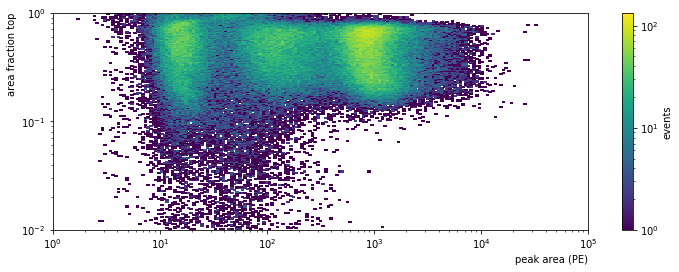

In [74]:
plot_area_top(peak_s1)

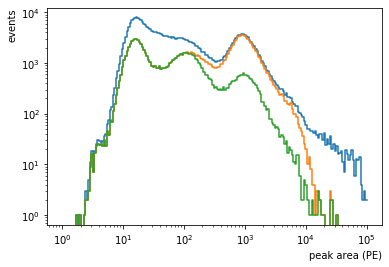

In [77]:
plot_area(peak_basics)
plot_area(peak_s1)
peak_cut = peak_s1[(peak_s1['max_pmt_area']/peak_s1['area']>0.05)]
plot_area(peak_cut)